# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import pickle
import cv2 as cv
import matplotlib.image as mpimg
import random

---
## Step 0: Load The Data

In [2]:
# TODO: Fill this in based on where you saved the training and testing data
data_dir = '/Users/rajeevkumar/Course/dataset/traffic/'
training_file = data_dir + "train.p"
validation_file= data_dir + "valid.p"
testing_file = data_dir + "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
print()
assert(len(X_train) > 0)
assert(len(X_valid) > 0)
assert(len(X_test) > 0)
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

In [4]:
import csv
def read_csv_dict(csv_file, key_col, val_col, header):
    out_dict = {}
    with open(csv_file) as csvfile:
        sign_reader = csv.reader(csvfile)
        for row in sign_reader:
            if header:
                header = False
                continue
            out_dict[row[key_col]] = row[val_col]
    return out_dict
            

In [5]:
sign_names = read_csv_dict('signnames.csv', 0, 1, True)
#sign_names

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [6]:
import numpy as np
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.union1d(np.union1d(y_train, y_valid), y_test).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print ("Number of validation examples = ", len(y_valid))
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples =  4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [7]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

In [8]:
def plot_images(images, x_dim, y_dim, labels=None):
    _, axis = plt.subplots(x_dim, y_dim)
    for i in range(x_dim):
        for j in range(y_dim):
            image_index = i * y_dim + j
            if image_index >= len(images):
                break
                
            axis[i,j].imshow(images[i * y_dim + j])
            if labels != None:
                axis[i,j].set_title(labels[image_index])

In [9]:
def plot_images_in_random(images, x_dim, y_dim):
    img_indexs = [x for x in range(len(images))]
    if (len(images) > (x_dim * y_dim)):
        random.shuffle(img_indexs)
    fig, axis = plt.subplots(x_dim, y_dim)
    for i in range(x_dim):
        for j in range(y_dim):
            image_index = i * y_dim + j
            if (image_index) >= len(images):
                break
            image = images[img_indexs[image_index]]
            if (image.shape[2] == 1):
                axis[i,j].imshow(image[:,:,0])
            else:
                axis[i, j].imshow(image)
    

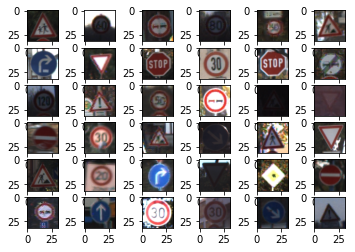

In [10]:
plot_images_in_random(X_train, 6,6)

(array([ 7200.,  4560.,  6180.,  3510.,  2550.,  2640.,  1470.,  1889.,
         1950.,  2850.]),
 array([  0. ,   4.2,   8.4,  12.6,  16.8,  21. ,  25.2,  29.4,  33.6,
         37.8,  42. ]),
 <a list of 10 Patch objects>)

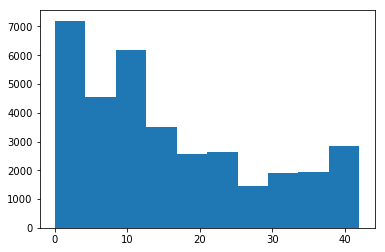

In [11]:
# plotting the distribution of classes
plt.hist(y_train)


(array([ 870.,  570.,  720.,  480.,  330.,  360.,  180.,  270.,  270.,  360.]),
 array([  0. ,   4.2,   8.4,  12.6,  16.8,  21. ,  25.2,  29.4,  33.6,
         37.8,  42. ]),
 <a list of 10 Patch objects>)

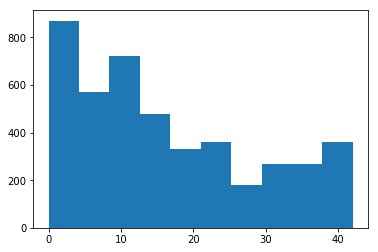

In [12]:
plt.hist(y_valid)

(array([ 2640.,  1680.,  2250.,  1350.,   900.,   930.,   480.,   690.,
          690.,  1020.]),
 array([  0. ,   4.2,   8.4,  12.6,  16.8,  21. ,  25.2,  29.4,  33.6,
         37.8,  42. ]),
 <a list of 10 Patch objects>)

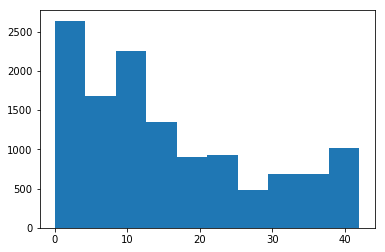

In [13]:
plt.hist(y_test)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [14]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale
### Feel free to use as many code cells as needed.

### Following steps are done in pre-processing the image  and why - 
#### 1. Converting into GRAY Image. - Noramalizing into gray scale image . This helps to learn faster as gradient acts uniformaly one each channel.
#### 2. Normalizing the pixel value between 0 to 1 - It improves the convergence faster. If the value of pixel was in the range of 0-255, It took more epoch to converge and even accuracy is 0.89 on validation set. On using the value between 0-1, gradients act uniformaly. 


In [15]:
def convert_RGB_to_GRAY(image):
    rgb_img = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    #rg_img = cv.normalize(rgb_img, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
    return rgb_img[:,:, np.newaxis]

In [16]:
def preprocess_image(x):
    gray_image = lambda t : convert_RGB_to_GRAY(t)
    
    x = np.array(list(map(gray_image, x)))
    x = x.astype(float)/128.0
    return x

In [17]:
X_train = preprocess_image(X_train)
X_valid = preprocess_image(X_valid)
X_test =  preprocess_image(X_test)

Plotting training images after preprocessing

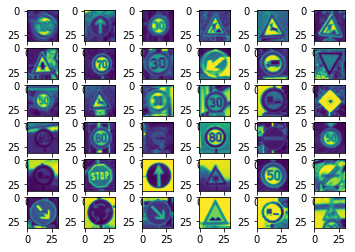

In [18]:
plot_images_in_random(X_train, 6, 6)

### Model Architecture

In [19]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

## Model Architecture - 
### Layer	Description
Input	32x32x1 GRAY Scale Image  
Convolution-1 5x5X1X10	stride = 1X1, Valid padding, outputs 28x28x10  
Activation - tanH	  
Max pooling	2x2 stride, outputs 14X14X10  
Convolution-2 5X5X10X32 stride = 1X1 Valid padding, output 10X10X32  
Activation - tanH  
Max pooling 2X2 stride - outputs = 5X5X32  
Fully connected	layers = 400 => 120 => 84 => No_class  
Softmax	Layer = No-Classes.  
Activation for fully connected layer is also tanH

In [20]:
#Model training
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [21]:
var_init_mean = 0.0
var_init_std_dev = 0.1

In [22]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [23]:
def applyActivationFun(x, act_fun):
    if act_fun.lower() == "relu":
        return tf.nn.relu(x)
    elif act_fun.lower() == "tanh":
        return tf.nn.tanh(x)
    elif act_fun.lower() == "pass":
        return x

In [24]:
def applyConvLayer(x, weight, bias, stride, padding, actFun):
    conv = tf.nn.bias_add(tf.nn.conv2d(x, weight, stride, padding), bias)
    return applyActivationFun(conv, actFun)

In [25]:
def applyForwardLayer(x, weight, bias, actFun):
    f1 = tf.add(tf.matmul(x, weight), bias)
    return applyActivationFun(f1, actFun)

In [26]:
def add_ConvLayer(x, in_channel, out_channel, stride, padding, actFun, name, mean=0.0, std_dev=0.1):
    with tf.name_scope(name):
        with tf.name_scope("weights"):
            weight = tf.Variable(tf.random_normal([5,5,in_channel, out_channel], mean=mean, stddev=std_dev), name="weight")
            variable_summaries(weight)
            
        with tf.name_scope("biases"):
            bias = tf.Variable(tf.zeros([out_channel]), name="bias")
            variable_summaries(bias)
        
        conv = tf.nn.bias_add(tf.nn.conv2d(x, weight, stride, padding), bias)
        act = applyActivationFun(conv, act_fun=actFun)
        
        # Apply pooling layer
        pool = tf.nn.max_pool(act, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID", name="max_pool")
        
        return pool

In [27]:
def add_feedforward_layer(x, in_dim, out_dim, name, actFun, mean=0.0, std_dev = 0.1):
    with tf.name_scope(name):
        with tf.name_scope("weights"):
            rand_W = tf.Variable(tf.random_normal([in_dim, out_dim], mean=mean, stddev=std_dev), name="weight")
            variable_summaries(rand_W)
        
        with tf.name_scope("biases"):
            zero_b = tf.zeros([out_dim], name="bias")
            variable_summaries(zero_b)
            
        return applyForwardLayer(x, rand_W, zero_b, actFun)

In [28]:
def traffic_sign_net(x, n_classes):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    actFun= "tanh"
    
    stride_1 = [1, 1, 1, 1]
    stride_2 = [1, 2, 2, 1]
    pool_kernel_2 = [1, 2, 2, 1]
    
    #32*32*1 => 28*28*10 => 14 * 14 * 16
    conv_layer_1 = add_ConvLayer(x, 1, 10, stride=stride_1, padding="VALID", actFun=actFun, name="Conv_L1")
    
    #14*14*16 => 10*10*16 => 5*5*16
    conv_layer_2 = add_ConvLayer(conv_layer_1, 10, 32, stride=stride_1, padding="VALID", actFun=actFun, name="Conv_L2")
    
    with tf.name_scope("flatten"):
        #conv1_flat = tf.reshape(conv_layer_1, shape=[-1, 14 * 14 * 16])
        #conv2_flat = tf.reshape(conv_layer_2, shape=[-1, 5 * 5 * 32])
        
        #flatten_in = tf.concat([conv1_flat, conv2_flat], 1)
        #print(tf.shape(flatten_in))
        # flattend dim
        flat_dim = 5 * 5 * 32
        flatten_in = tf.reshape(conv_layer_2, shape = [-1, 5 * 5 * 32])
        
    
    feed_forward_dim = [flat_dim, 120, 84, n_classes]
    ffout_1 = add_feedforward_layer(flatten_in, feed_forward_dim[0], feed_forward_dim[1], "ff_1", actFun=actFun)
    
    ffout_2 = add_feedforward_layer(ffout_1, feed_forward_dim[1], feed_forward_dim[2], "ff_2", actFun=actFun)
    
    output_layer = add_feedforward_layer(ffout_2, feed_forward_dim[2], feed_forward_dim[3], "ff_3", "pass")   
    
    return output_layer

### Train, Validate and Test the Model




A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [29]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [30]:
rate = 0.001
traffic_net = traffic_sign_net(x, n_classes)

In [31]:
with tf.name_scope("xentropy"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=traffic_net)
    loss_operation = tf.reduce_mean(cross_entropy, name="reduced_mean")
    tf.summary.scalar("cross_entroy_mean", loss_operation)

In [32]:
with tf.name_scope("train"):
    #optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    optimizer = tf.train.AdamOptimizer(learning_rate=rate)
    training_operation = optimizer.minimize(loss_operation)

In [33]:
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(traffic_net, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy_operation)

In [34]:
with tf.name_scope("model_predication_index"):
    prediction_index = tf.argmax(traffic_net, 1)

In [35]:
with tf.name_scope("softmax_layer"):
    softmax_layer = tf.nn.softmax(traffic_net)

In [36]:
with tf.name_scope("topk_softmax_out"):
    top_k = tf.placeholder(tf.int32)
    softmax_topk_layer = tf.nn.top_k(softmax_layer, top_k)

In [37]:
saver = tf.train.Saver()

In [38]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [39]:
def predict(images):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        prediction = sess.run(prediction_index, feed_dict={x:images})
        return prediction

## Different Hyper paramters are used to train the model.
##### optimizer = Adam, Batchsize =128 , epochs=10, learning_rate=0.02, valid_accuracy= 0.935 test_accuracy=0.91  
##### optimizer=Adam, Batchsize=128, epochs=20, learning_rate=0.02, valid_accuracy=0.30 , test_accuracy=0.91
### conclusion - epochs changing are does not impactng validation set and test accuracy much.

#### optimer = Adam, Batchsize = 128, epochs=20, learning_rate=0.05, validation_accuracy=0.037, test_accuracy=0.037 . It is observed, model keep diverging and vacillating on higher learning rate.

### 3. Choosen Model Hyper parameters -   
#### optimizer = Adam  
#### Batch size = 128  
#### Learning rate = 0.01  
#### Epochs = 20 - Model converges in 20 epochs and there is no fluctuation in validation and dev set accuracy. This is best epoch found on trying with 5, 10, 15, 20, 25 epochs.  
#### mean for filter and wieght paramters initialization = 0.0  
#### std deviation for filter and weight paramter initialization = 0.1  



## CASE -1 
Input	32x32x1 GRAY Scale Image
Convolution-1 5x5X1X10	stride = 1X1, Valid padding, outputs 28x28x10
Activation - tanH	
Max pooling	2x2 stride, outputs 14X14X10
Convolution-2 5X5X10X32 stride = 1X1 Valid padding, output 10X10X32
Activation - tanH
Max pooling 2X2 stride - outputs = 5X5X32
Fully connected	layers = 400 => 120 => 84 => No_class
Softmax	Layer = No-Classes.
Activation for fully connected layer is also tanH
### Validation score = 0.960
### Test score = 0.934

## CASE -2
Input	32x32x1 GRAY Scale Image
Convolution-1 5x5X1X10	stride = 1X1, Valid padding, outputs 28x28x10
Activation - RELU	
Max pooling	2x2 stride, outputs 14X14X10
Convolution-2 5X5X10X32 stride = 1X1 Valid padding, output 10X10X32
Activation - RELU
Max pooling 2X2 stride - outputs = 5X5X32
Fully connected	layers = 400 => 120 => 84 => No_class
Softmax	Layer = No-Classes.
Activation for fully connected layer is also tanH
### Validation score = 0.920
### Test score = 0.887

OBSERVATIONS -
1. TanH activation function converges faster than RELU

In [40]:
from sklearn.utils import shuffle
EPOCHS = 20
BATCH_SIZE = 128
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    writer = tf.summary.FileWriter("./tf/4")
    writer.add_graph(sess.graph)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        train_size = int(0.97*len(X_train))
        X_train_epoch = X_train[: train_size]
        y_train_epoch = y_train[: train_size]
        X_dev_epoch = X_train[train_size:]
        y_dev_epoch = y_train[train_size:]
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_epoch[offset:end], y_train_epoch[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        dev_accuracy = evaluate(X_dev_epoch, y_dev_epoch)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Dev Accuracy = {:.3f}".format(dev_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './traffic')
    print("Model saved")

Training...

EPOCH 1 ...
Dev Accuracy = 0.899
Validation Accuracy = 0.859

EPOCH 2 ...
Dev Accuracy = 0.975
Validation Accuracy = 0.927

EPOCH 3 ...
Dev Accuracy = 0.978
Validation Accuracy = 0.932

EPOCH 4 ...
Dev Accuracy = 0.995
Validation Accuracy = 0.938

EPOCH 5 ...
Dev Accuracy = 0.992
Validation Accuracy = 0.943

EPOCH 6 ...
Dev Accuracy = 0.995
Validation Accuracy = 0.944

EPOCH 7 ...
Dev Accuracy = 0.999
Validation Accuracy = 0.953

EPOCH 8 ...
Dev Accuracy = 0.998
Validation Accuracy = 0.948

EPOCH 9 ...
Dev Accuracy = 1.000
Validation Accuracy = 0.954

EPOCH 10 ...
Dev Accuracy = 1.000
Validation Accuracy = 0.956

EPOCH 11 ...
Dev Accuracy = 1.000
Validation Accuracy = 0.959

EPOCH 12 ...
Dev Accuracy = 1.000
Validation Accuracy = 0.956

EPOCH 13 ...
Dev Accuracy = 0.978
Validation Accuracy = 0.910

EPOCH 14 ...
Dev Accuracy = 0.998
Validation Accuracy = 0.951

EPOCH 15 ...
Dev Accuracy = 0.999
Validation Accuracy = 0.949

EPOCH 16 ...
Dev Accuracy = 1.000
Validation Accura

In [41]:
# Test your model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./traffic
Test Accuracy = 0.942


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [42]:
def image_read(image_path):
    image = cv.imread(image_path)
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

In [43]:
def image_read_resize(image_path, resize = (32,32)):
    image = cv.resize(image_read(image_path), resize)
    return image

### Load and Output the Images

In [44]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [45]:
test_images_path = ["./examples/speed_limit_80.jpg",
                    "./examples/do-not-enter.jpg",
                    "./examples/yield-sign.jpg",
                    "./examples/pedestrain-crossing.jpg",
                    "./examples/stop_sign.jpg"]

In [46]:
read_images = lambda x : image_read(x)

In [47]:
test_images_ori = list(map(read_images, test_images_path))

German Traffic Images downloaded randomly from web

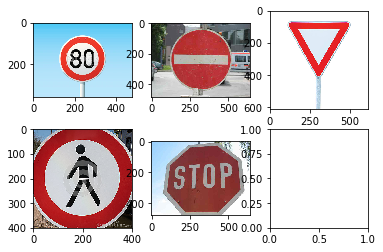

In [48]:
plot_images(test_images_ori, 2, 3)

In [49]:
resize_image_lam = lambda x : image_read_resize(x)

In [50]:
test_images_resize = list(map(resize_image_lam, test_images_path))

Images After re-sizing into 32X32X3

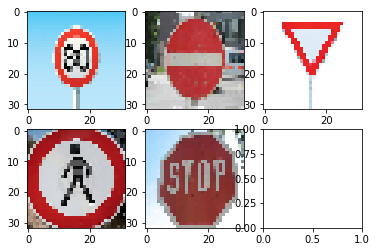

In [51]:
plot_images(test_images_resize, 2, 3)

### Predict the Sign Type for Each Image

In [52]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

In [53]:
test_images_processed = preprocess_image(np.array(test_images_resize))

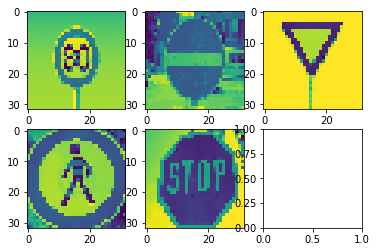

In [54]:
plot_images_in_random(test_images_processed, 2, 3)

In [55]:
test_images_expected = [5, 17, 13, 27, 14]

In [56]:
test_images_predicted = predict(test_images_processed).tolist()

INFO:tensorflow:Restoring parameters from ./traffic


In [57]:
predicted_labels = []
for t in test_images_predicted:
    predicted_labels.append(sign_names[str(t)])

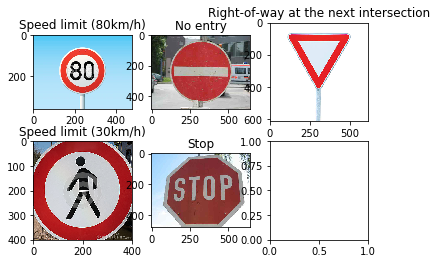

In [58]:
plot_images(test_images_ori, 2, 3, predicted_labels)

In [59]:
from IPython.display import HTML

In [60]:
from IPython.display import display

In [61]:
def generate_html_for_table(matrix):
    tablestr = "<table>"
    # first row is header
    for i in range(len(matrix)):
        tablestr = tablestr + "<tr>"
        for j in range(len(matrix[i])):
            if( i ==0):
                tablestr += "<th>" + matrix[i][j] + "</th>"
            else:
                tablestr += "<td>" + matrix[i][j] + "</td>"
        tablestr = tablestr + "</tr>"
    tablestr = tablestr + "</table>"
    return tablestr

In [62]:
prediction = [
    ["Image", "Prediction"],
    ["Speed Limit(80 km/h)", "Speed Limit(80 km/h)"],
    ["No Entry", "No Entry"],
    ["Yield", "Right-of-way at next intersection"],
    ["Pedestrian crossing", "Stop"],
    ["Stop", "Stop"]
]

In [63]:
display(HTML(generate_html_for_table(prediction)))

Image,Prediction
Speed Limit(80 km/h),Speed Limit(80 km/h)
No Entry,No Entry
Yield,Right-of-way at next intersection
Pedestrian crossing,Stop
Stop,Stop


### Analyze Performance

In [64]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [65]:
test_images_expected = [5, 17, 28, 27, 14]

In [66]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    accuracy = evaluate(test_images_processed, test_images_expected)
    print("Accuracy of model on random web samples is - " + str(accuracy))

INFO:tensorflow:Restoring parameters from ./traffic
Accuracy of model on random web samples is - 0.600000023842


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [67]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

In [68]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    softmax_topk_out = sess.run(softmax_topk_layer, feed_dict={x:test_images_processed, top_k:5})
    print(softmax_topk_out)

INFO:tensorflow:Restoring parameters from ./traffic
TopKV2(values=array([[  9.97868180e-01,   1.02272793e-03,   6.87174033e-04,
          1.57535280e-04,   1.40909149e-04],
       [  9.99973655e-01,   8.16904867e-06,   4.44762281e-06,
          2.87670241e-06,   2.08878578e-06],
       [  4.56276715e-01,   3.17776948e-01,   9.59002301e-02,
          3.28362919e-02,   3.26594003e-02],
       [  8.91126275e-01,   3.62390913e-02,   2.81223990e-02,
          1.71892717e-02,   8.66657589e-03],
       [  6.15080655e-01,   2.31625587e-01,   7.39743263e-02,
          4.49630469e-02,   1.38260163e-02]], dtype=float32), indices=array([[ 5,  1,  6,  2, 31],
       [17, 33, 14, 12,  9],
       [11,  6, 21, 42, 38],
       [ 1, 18,  4, 21,  0],
       [14, 33,  3, 34,  1]], dtype=int32))


In [69]:
top_5_probability = [
    ["Image", "Predict-Top1", "Predict-Top-2", "Predict-Top3", "Predict-Top4", "Predict-Top5"],
    ["Speed Limit(80 km/h)", "SL(80 km/h)-0.65","SL 30Km/h-0.27", "SL 120Km/h-0.021", "SL 60Km/h-0.014", "SL 20Km/h-0.01"],
    ["No Entry", "No Entry-0.99", "No passing-0.003", "RM-~0.00", "TL-~0.00", "SL 20Km/h-~0.00"],
    ["Yield", "Right of way at NI-0.97", "ESL 80Km/h-0.018", "EOP-0.0023", "SL 30Km/h-~0.0", "KR-~0.0"],
    ["Pedestrian crossing", "Stop-0.45", "SL 50Km/h-0.40", "SL 70Km/h-0.05","GSR 0.017", "SL 30Km/h-0.014"],
    ["Stop", "Stop-0.96", "Sl 60Km/h-0.017", "TLA - 0.004", "SL 30Km/h - 0.002", "GSR - 0.0023"]
]

In [70]:
display(HTML(generate_html_for_table(top_5_probability)))

Image,Predict-Top1,Predict-Top-2,Predict-Top3,Predict-Top4,Predict-Top5
Speed Limit(80 km/h),SL(80 km/h)-0.65,SL 30Km/h-0.27,SL 120Km/h-0.021,SL 60Km/h-0.014,SL 20Km/h-0.01
No Entry,No Entry-0.99,No passing-0.003,RM-~0.00,TL-~0.00,SL 20Km/h-~0.00
Yield,Right of way at NI-0.97,ESL 80Km/h-0.018,EOP-0.0023,SL 30Km/h-~0.0,KR-~0.0
Pedestrian crossing,Stop-0.45,SL 50Km/h-0.40,SL 70Km/h-0.05,GSR 0.017,SL 30Km/h-0.014
Stop,Stop-0.96,Sl 60Km/h-0.017,TLA - 0.004,SL 30Km/h - 0.002,GSR - 0.0023


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [71]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")